# ARIMA and SARIMA
This notebook develops the arima model.

## Imports:

In [1]:
import pandas as pd
from pathlib import Path
import pmdarima as pm
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests
import pickle

## Data:

In [2]:
cwd=Path.cwd()
data= pd.read_csv(cwd.parent / 'Data' /'Train'/'train1990s.csv',parse_dates=[0],date_format='%m%Y',index_col=0)

transformedCols=[]
for i in data.columns:
    match=re.findall(r'fred_.*_.*',i)
    if match!=[]:
        transformedCols.append(match[0])

unmodifiedDf= data.drop(transformedCols,axis=1)
split= round(unmodifiedDf.shape[0]*0.9)
train= unmodifiedDf.iloc[:split+1,:]
valid= unmodifiedDf.iloc[split+1:,:]



In [3]:
def display_results(preds,actual):
    plt.plot(preds,label= 'Predictions')
    plt.plot(actual, label='Ground Truth')
    plt.xticks([])
    plt.legend()
    plt.show()

def difference2(col1:str,col2:str, df:pd.DataFrame):
    return(df[[col1,col2]].diff(1)).drop(0,axis=0)

# Preprocessing
ARIMA requires the data to be stationary, however AutoArima kindly handles it for you!

# ARIMA

0.3593294173266363


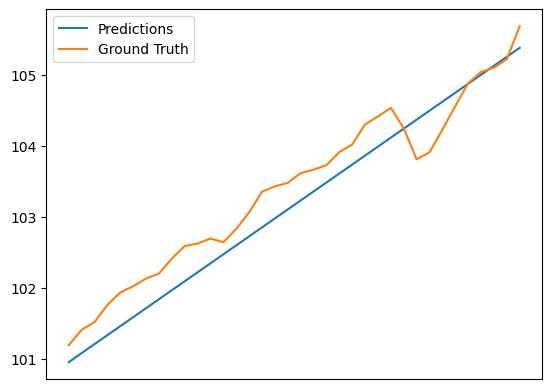

In [ ]:
#Make seasonal False for ARIMA (otherwise its SARIMA)
arima_model= pm.auto_arima(train['fred_PCEPI'],start_p=1, start_q=1,seasonal=False, stepwise=True)
preds=np.array(arima_model.predict(valid.shape[0]))
Y= np.array(valid.iloc[:,0])
print(root_mean_squared_error(Y,preds))
display_results(preds, valid.iloc[:,0])

# ARIMAX

1.3512039539925598


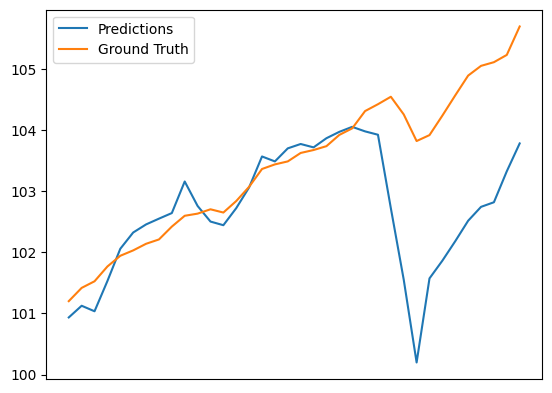

In [ ]:
#Make seasonal False for ARIMAX (otherwise its SARIMA)
arimax_model= pm.auto_arima(y=train['fred_PCEPI'],X=train.drop(['fred_PCEPI'],axis=1),start_p=1, start_q=1,seasonal=False, stepwise=True)
preds=np.array(arimax_model.predict(valid.shape[0],valid.drop(['fred_PCEPI'],axis=1)))
Y= np.array(valid['fred_PCEPI'])

print(root_mean_squared_error(Y,preds))
display_results(preds,Y)

## SARIMA

0.5460175398578553


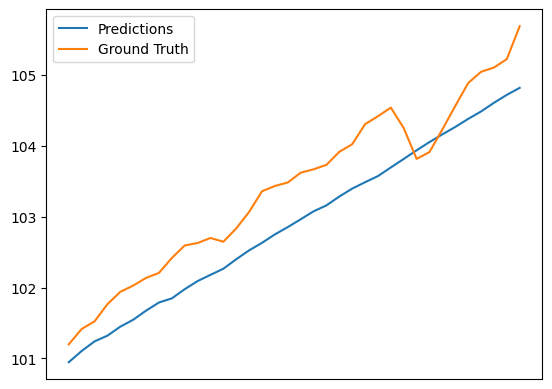

In [ ]:
#change seasonal to True and m=12 for SARIMA
sarima_model= pm.auto_arima(train['fred_PCEPI'],start_p=1, start_q=1,seasonal=True,m=12, stepwise=True)
preds=np.array(sarima_model.predict(valid['fred_PCEPI'].shape[0]))
Y= np.array(valid.iloc[:,0])
print(root_mean_squared_error(Y,preds))
display_results(preds, Y)

## SARIMAX

1.3512039539925598


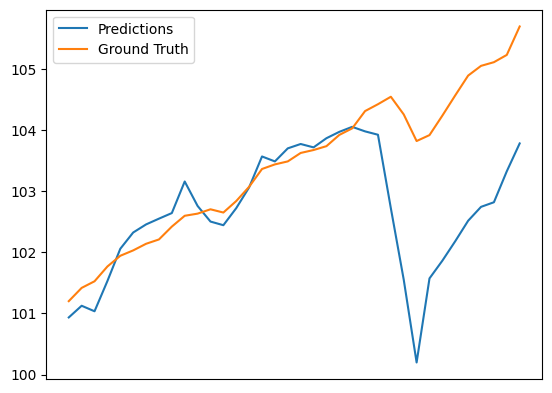

In [ ]:
#change seasonal to True and m=12 for SARIMA
sarimax_model= pm.auto_arima(y=train['fred_PCEPI'],X=train.drop(['fred_PCEPI'],axis=1),start_p=1, start_q=1,m=12,seasonal=True, stepwise=True)
preds=np.array(sarimax_model.predict(valid.shape[0],valid.drop(['fred_PCEPI'],axis=1)))
Y= np.array(valid['fred_PCEPI'])

print(root_mean_squared_error(Y,preds))
display_results(preds,Y)

As shown ARIMAX and SARIMAX are sensitive to large numbers of exogfenous variables, therfore some method is required to rank the best features:
mutual_info_regression
cross correlation
Variance Inflation Factor (VIF) (Remove variables with VIF > 5–10 to avoid unstable coefficient estimates)


## Feature Selection:
ARIMAX and SARIMAX are sensitive to the amount of feratures used and should

In [ ]:

def difference2Cols(col1:str,col2:str, df:pd.DataFrame, n:int):
    '''
    This function differences 2 variables, to achieve stationarity

    Parameters:
    -----------
    col1: Name of the 1st column to be differenced.
    col2: Name of the 2nd column to be differenced.
    df: Dataframe which has the data for col1 and col2.
    n: The Order of differencing.
    Returns:
    ---------
    A pandas dataframe with 2 columns with the differenced data (removing the nulls).
    '''
    return df[[col1,col2]].diff(n).iloc[n:,:]

def make_sationary(col1:str,col2:str, df:pd.DataFrame):

    '''
    This function makes 2 columns of a dataframe stationary, by taking the minimal nth difference which achieves
    stationarity (using the dickey-fuller stationarity test with a significance level of 5%).

    Parameters:
    -----------
    col1: Name of the 1st column, which needs to be transformed into a stationary time series.
    col2: Name of the 2nd column, which needs to be transformed into a stationary time series.
    df: Dataframe which has the data for col1 and col2.

    Returns:
    --------
    Returns a pandas dataframe with 2 columns of the stationary data. NOTE: if no stationarity is achieved, NaN is returned.
    '''
     # Check both variables are stationary:
    if adfuller(df[col1])[1]<0.05 and adfuller(df[col2])[1]<0.05:
        return df[[col1,col2]]

    for i in range(1,13):
        
        diffDf= difference2Cols(col1,col2,df,i)# Difference data to try achive stationarity
        # Check for stationarity:
        if adfuller(diffDf[col1])[1]<0.05 and adfuller(diffDf[col2])[1]<0.05:
            return diffDf
        
    # Return NaN if no differencing achieved stationarity within 12 iterations      
    return np.nan


def find_best_corr(target:str,col2:str, df:pd.DataFrame):

    '''
    This function finds the maximal cross correlation between target and col2, using 12 lags (year).
    NOTE: for reliable cross correlation results, the time series needs to be stationary, hence make_sationary is used.
    NOTE: if stationarity is NOT achieved, then NaN is returned.

    Parameters:
    -----------
    target: The name of the target column.
    col2: The name of the other column which is used to calculate the cross correlation between the target.
    df: Dataframe which has the data for target and col2.

    Returns:
    --------
    returns maximal cross correlation out of the 12 time lagged cross correlation values.
    '''
    # Make time-series stationary:
    stationary_df=make_sationary(target,col2,df)

    # Return NaN if stationarity is NOT achieved:
    if stationary_df is np.nan:
        return np.nan
    
    # Return maximal ccf value:
    return np.max(np.abs(ccf(stationary_df[col2],stationary_df[target],nlags=12)))



def granger_causes(target:str,col:str,df:pd.DataFrame):
    '''
    Perfom granger causlaity test, where the following is tested: col granger-causes target, with a
    5% significance level.

    Parameters:
    -----------
    target: The name of the target column.
    col: The name of the other column which granger-causes target.
    df: Dataframe which has the data for target and col2.

    Returns:
    --------
    A boolean value, True if col granger cause target, else False.

    '''
    # calculate the p-values
    granger=grangercausalitytests(df[[target,col]],maxlag=12,verbose=False)

    # loop over all the lags:
    for key in granger.keys():
        # Check if it is significant using 5% significance level
        if granger[key][0]['ssr_chi2test'][1]<0.05:
            return True
    return False

def rank_best_features_arima(df, targetCol):

    '''
    This function ranks the exogenous variables by ccf value.

    Parameters:
    -----------
    df: pandas dataframe containing all the exogenous data and target data.

    targetCol: name of the target column in df.

    Returns:
    --------
    Returns pandas dataframe where the columns are ordered by ccf value in descending order.
    '''

    df_selected= df.copy()
    
    dropCols=[]
    # Loop over columns:
    for col in df_selected.columns.drop(targetCol):

        stationary= make_sationary(targetCol,col,df_selected)# makes stime series stationary

        #remove columns which do not achieve stationarity
        if stationary is np.nan:
            dropCols.append(col)
        # Removes columnns which do not granger cause (sanity check)
        elif not granger_causes(targetCol,col,df_selected):
            dropCols.append(col)
    
    df_selected.drop(dropCols, axis=1, inplace=True)

    #Calculkate the cross correlation values:
    corrs=[]
    for exog in df_selected.columns.drop('fred_PCEPI'):
        x= find_best_corr('fred_PCEPI',exog,unmodifiedDf)
        if x is np.nan:
            x=0.
        corrs.append(x)
    
    best_corrs=np.argsort(corrs)[::-1] +1

    return df_selected.iloc[:,np.insert(best_corrs,0,0)]




def SARIMAX_grid_search(ranked_df,targetCol, valid=0.1, top_n=20):
    '''
    Performs a grid search on the optimal number of exogenous variables to use.

    Parameters:
    -----------
    ranked_df: pandas dataframe where the columns are ordered in descending order of predictive power (ccf in this case).

    targetCol: name of target column in ranked_df.

    valid: the validation size (deafults to 10% of traing data).

    top_n: gridsearch up top_n exogenous variables in total.

    Returns:
    --------
    Tuple, where the 1st element is the optimal RMSE value,
    the 2nd element is the best number of features to use. 
    '''
    # separate the taget to the exogenous variables:
    target= ranked_df[targetCol]
    df_exog= ranked_df.drop(targetCol, axis=1)

    # Split into training data and validation data
    split= round(ranked_df.shape[0]*(1. - valid))
    train_exog= df_exog.iloc[:split+1,:]
    valid_exog= df_exog.iloc[split+1:,:]

    train_target= target.iloc[:split+1]
    valid_target= target.iloc[split+1:]

    # Values used to find the optimal solution
    best_score=999
    best_n=-1

    # loop over possible n's:
    for i in range(1,top_n+1):
        #train model:
        sarimax_model= pm.auto_arima(y=train_target,X=train_exog.iloc[:,:i],start_p=1, start_q=1,m=12,seasonal=True, stepwise=True)

        #Infer on the validation data:
        preds=np.array(sarimax_model.predict(valid_exog.shape[0],valid_exog.iloc[:,:i]))
        
        # Calulate RMSE score
        Y= np.array(valid_target)
        score=root_mean_squared_error(Y,preds)

        # Update if a new minimum is found:
        if score < best_score:
            best_score=score
            best_n=i


    print(f"Best score: {best_score}")
    print(f"Best number of features: {best_n}")

    return best_score, best_n

## Find optimal number of exogenous variables:

In [5]:
ranked_df=rank_best_features_arima(unmodifiedDf,'fred_PCEPI')
SARIMAX_grid_search(ranked_df,'fred_PCEPI', top_n=20,valid=0.2)

c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  

Best score: 0.20367743319713377
Best number of features: 9


(0.20367743319713377, 9)

10% validation size:

Best score: 0.39031823257263404

Best number of features: 11

20% validation size:

Best score: 0.20367743319713377

Best number of features: 9

Using a validaion size of 10% overfitted, hence 20% generalized better.

## Train final model:

trains the model using the optimal parameters and saves the model to a pickle file

0.20367743319713377


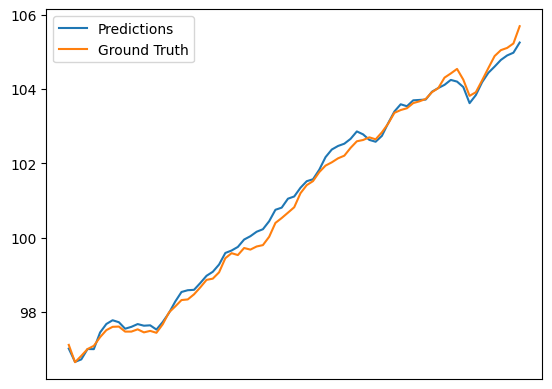

0.20367743319713377


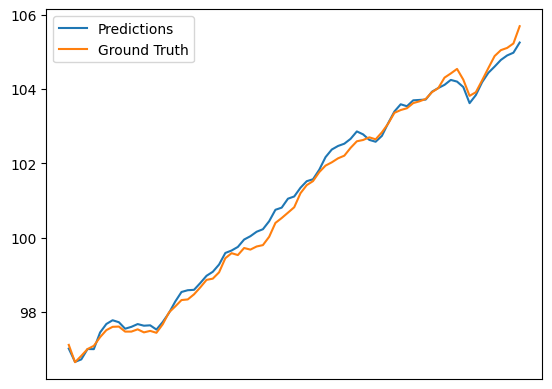

In [ ]:
target= ranked_df['fred_PCEPI']
df_exog= ranked_df.drop('fred_PCEPI', axis=1)

split= round(ranked_df.shape[0]*(0.8))
train_exog= df_exog.iloc[:split+1,:]
valid_exog= df_exog.iloc[split+1:,:]

train_target= target.iloc[:split+1]
valid_target= target.iloc[split+1:]
sarimax_model_optimal= pm.auto_arima(y=train_target,X=train_exog.iloc[:,:9],start_p=1, start_q=1,m=12,seasonal=True, stepwise=True)
preds=np.array(sarimax_model_optimal.predict(valid_exog.shape[0],valid_exog.iloc[:,:9],axis=1))
Y= np.array(valid_target)

print(root_mean_squared_error(Y,preds))
display_results(preds,Y)
with open('../Models/Weights/SARIMAX_valid_20.pkl','wb') as f:
    pickle.dump(sarimax_model_optimal,f)

### Train on all training Data:
using optimal exogenous variables

NOTE: no validation is used and could be overfit (test set needed to decide)

In [ ]:
target= ranked_df['fred_PCEPI']
df_exog= ranked_df.drop('fred_PCEPI', axis=1)
sarimax_model_optimal_full= pm.auto_arima(y=target,X=df_exog.iloc[:,:9],start_p=1, start_q=1,m=12,seasonal=True, stepwise=True)

with open('../Models/Weights/SARIMAX_full_train.pkl','wb') as f:
    pickle.dump(sarimax_model_optimal_full,f)

# Evaluation:


## Validted Model:

In [ ]:
with open('../Models/Weights/SARIMAX_valid_20.pkl','rb') as f:
    loaded_model=pickle.load(f)

    preds=np.array(loaded_model.predict(valid_exog.shape[0],valid_exog.iloc[:,:9],axis=1))
    Y= np.array(valid_target)

    print(root_mean_squared_error(Y,preds))
    display_results(preds,Y)

## Un-validated Model:

In [ ]:
with open('../Models/We/SARIMAX_full_train.pkl','rb') as f:
    loaded_model=pickle.load(f)

    preds=np.array(loaded_model.predict(valid_exog.shape[0],valid_exog.iloc[:,:9],axis=1))
    Y= np.array(valid_target)

    print(root_mean_squared_error(Y,preds))
    display_results(preds,Y)